Considered only building_id = 1 and meter = 0.

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, Reshape, Flatten, BatchNormalization, Dropout, LeakyReLU
import matplotlib.pyplot as plt

# Load CSV file
data = pd.read_csv('train.csv')

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Filter data for building_id = 1 and meter = 0
data = data[(data['building_id'] == 1) & (data['meter'] == 0)]

# Extract time features: hour of the day and day of the week
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Encode time features using sin and cos to capture cyclical patterns
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Drop unnecessary columns
data = data[['meter_reading', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']]

# Normalize all features
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data)

# Create sequences of time series data
def create_sequences(group, sequence_length=24):
    sequences = []
    for i in range(len(group) - sequence_length):
        seq = group.iloc[i:i + sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences for the selected data
sequence_length = 24  # Number of hours to look back
sequences = create_sequences(data, sequence_length)

# Check if sequences are generated
if len(sequences) == 0:
    raise ValueError("No valid sequences generated. Check input data and sequence length.")
    
print(f"Generated {len(sequences)} sequences of shape {sequences.shape}")

# Split data into training and testing
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
test_data = sequences[train_size:]

# GAN for Synthetic Data Generation

# Define generator with LSTM
def build_generator(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128)(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(sequence_length * 5)(x)
    x = Reshape((sequence_length, 5))(x)
    
    # Add LSTM to generate time-dependent sequences
    x = LSTM(64, return_sequences=True)(x)
    x = Dense(5, activation='sigmoid')(x)
    model = Model(inputs, x)
    return model

# Define discriminator with LSTM
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32)(x)
    x = Dense(64)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)  # Output probability
    model = Model(inputs, x)
    return model

# Set input shape for generator and discriminator
input_shape = sequence_length * 5

# Build and compile the discriminator
discriminator = build_discriminator((sequence_length, 5))
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), 
                      loss='binary_crossentropy', metrics=['accuracy'])

# Build the generator
generator = build_generator(input_shape)

# Create GAN by combining generator and discriminator
discriminator.trainable = False  # Freeze discriminator for GAN training
gan_input = Input(shape=(input_shape,))
generated_sequence = generator(gan_input)
gan_output = discriminator(generated_sequence)

# Build and compile the GAN
gan = Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Training GAN
def train_gan(generator, discriminator, gan, epochs, batch_size=32):
    for epoch in range(epochs):
        # Get a random set of real sequences
        idx = np.random.randint(0, train_data.shape[0], batch_size)
        real_sequences = train_data[idx]

        # Generate fake sequences
        noise = np.random.normal(0, 1, (batch_size, input_shape))
        generated_sequences = generator.predict(noise)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Enable discriminator for real and fake data training
        discriminator.trainable = True
        # Train discriminator on real and fake sequences
        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_sequences, fake_labels)
        
        # Disable discriminator during generator training
        discriminator.trainable = False
        # Average discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator via GAN
        noise = np.random.normal(0, 1, (batch_size, input_shape))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss[0]} | G Loss: {g_loss}")

# Train the GAN
train_gan(generator, discriminator, gan, epochs=3000, batch_size=64)

# Save trained generator model
generator.save('generator_model.h5')
print("Generator model saved successfully!")

# Generate synthetic sequences
num_samples_to_generate = 1000
noise = np.random.normal(0, 1, (num_samples_to_generate, input_shape))
synthetic_data = generator.predict(noise)

# Inverse transform the normalized data
synthetic_data_flattened = synthetic_data.reshape(-1, 5)
synthetic_data_flattened = scaler.inverse_transform(synthetic_data_flattened)

# Reshape synthetic data to original format
synthetic_data_reshaped = synthetic_data_flattened.reshape(num_samples_to_generate, sequence_length, 5)

# Create synthetic dataframe for meter_reading
synthetic_meter_reading = synthetic_data_reshaped[:, :, 0]
synthetic_df = pd.DataFrame(synthetic_meter_reading, columns=[f'meter_reading_{i}' for i in range(sequence_length)])

# Save synthetic data to CSV
synthetic_df.to_csv('synthetic_data.csv', index=False)

print(f"Synthetic data generated successfully and saved to 'synthetic_data.csv'")

Generated 8760 sequences of shape (8760, 24, 5)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
Epoch 0/3000 | D Loss: 0.711139440536499 | G Loss: 0.7185483574867249
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━

Generator model saved successfully!
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Synthetic data generated successfully and saved to 'synthetic_data.csv'


EVALUATION OF THE GAN MODEL

Real Data Statistics:
Mean: 74.86539308970856 | Std: 61.76187330675348 | Min: 0.0 | Max: 255.0

Synthetic Data Statistics:
Mean: 135.67129253266668 | Std: 38.81357310190923 | Min: 22.48702 | Max: 235.20868

KS Test Statistic: 0.4412 | P-value: 0.0000
Reject null hypothesis: Real and synthetic data distributions are significantly different.



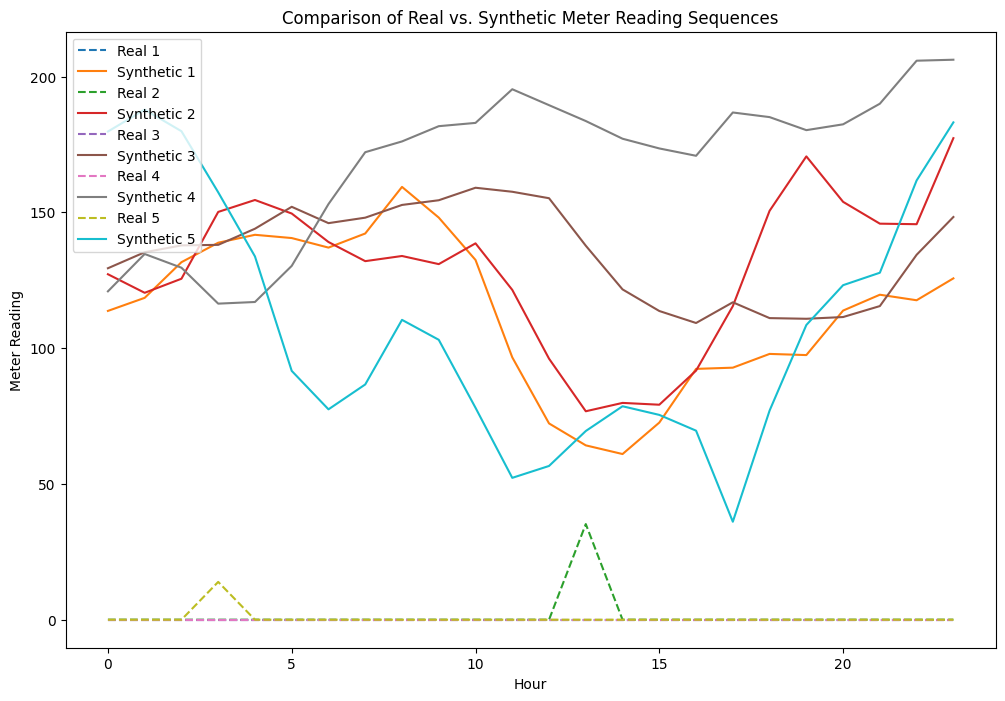

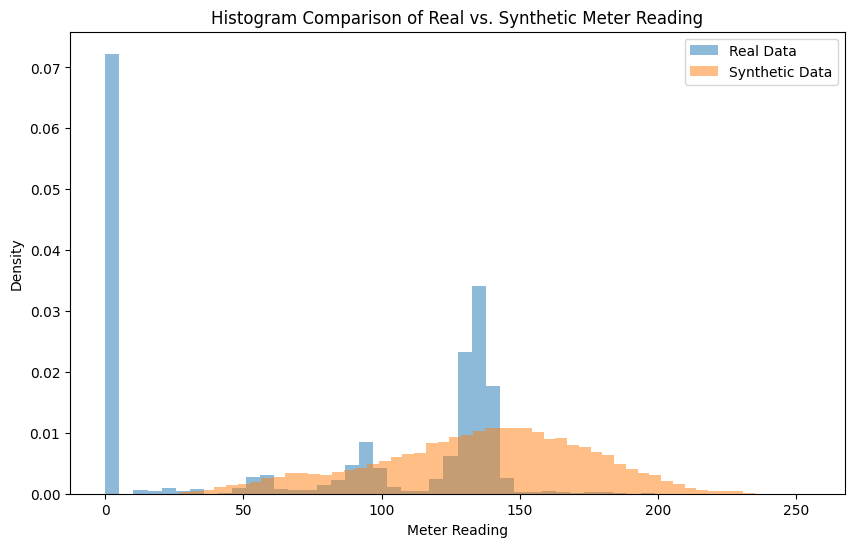

Real Data Model Evaluation:
Mean Squared Error (MSE): 34.2380
Mean Absolute Error (MAE): 2.8563
R-squared (R2): 0.9904

Synthetic Data Model Evaluation:
Mean Squared Error (MSE): 201.5620
Mean Absolute Error (MAE): 11.3846
R-squared (R2): 0.9181



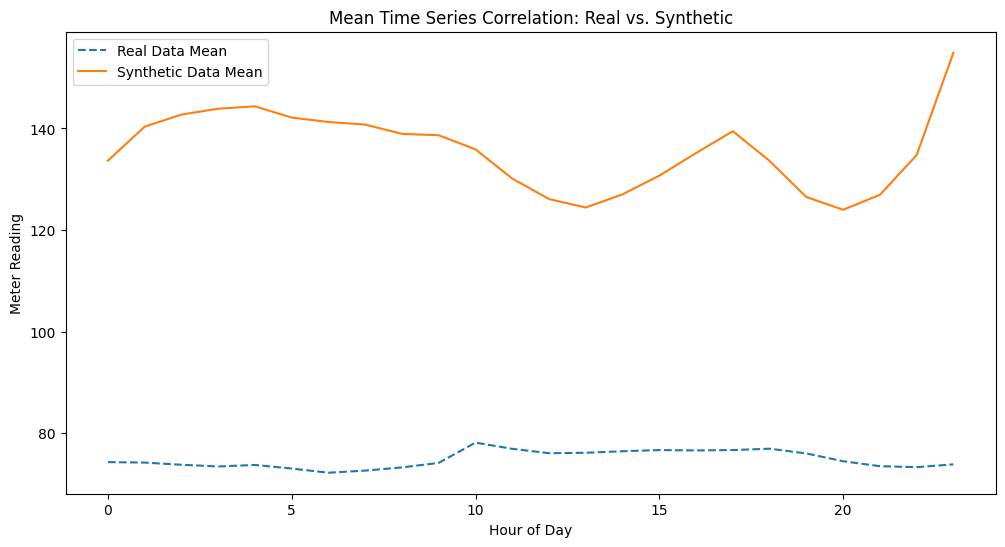

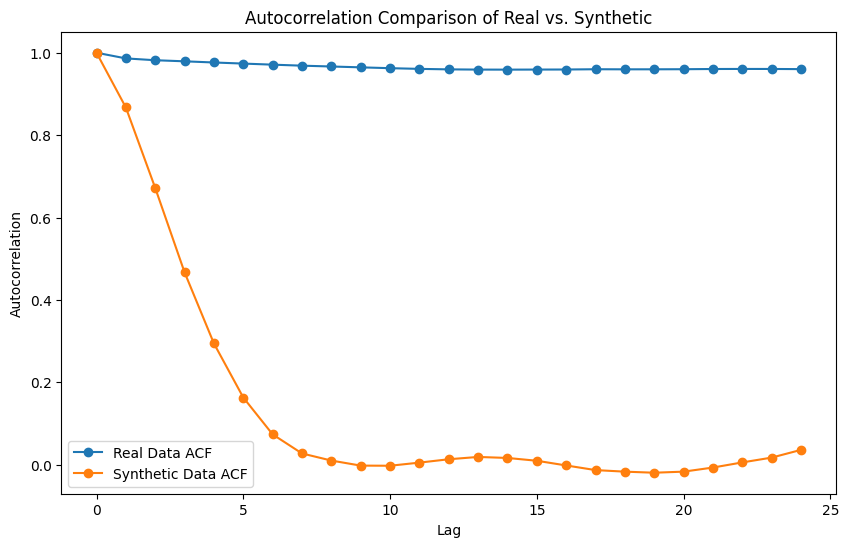

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ks_2samp

# Load real and synthetic data
real_data = pd.read_csv('train.csv')

# Filter real data for building_id = 1 and meter = 0
real_data = real_data[(real_data['building_id'] == 1) & (real_data['meter'] == 0)]

# Extract and normalize real data
real_data['timestamp'] = pd.to_datetime(real_data['timestamp'])
real_data['hour'] = real_data['timestamp'].dt.hour
real_data['day_of_week'] = real_data['timestamp'].dt.dayofweek
real_data['hour_sin'] = np.sin(2 * np.pi * real_data['hour'] / 24)
real_data['hour_cos'] = np.cos(2 * np.pi * real_data['hour'] / 24)
real_data['day_sin'] = np.sin(2 * np.pi * real_data['day_of_week'] / 7)
real_data['day_cos'] = np.cos(2 * np.pi * real_data['day_of_week'] / 7)

# Drop unnecessary columns and normalize
real_data = real_data[['meter_reading', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']]

# Load synthetic data
synthetic_data = pd.read_csv('synthetic_data.csv')

# Reshape synthetic data to match real data format
sequence_length = 24
synthetic_meter_reading = synthetic_data.values.reshape(-1, sequence_length)

# Flatten real data to match synthetic shape for comparison
real_meter_reading = real_data['meter_reading'].values[:synthetic_meter_reading.size].reshape(-1, sequence_length)

# --- 1. Statistical Evaluation ---

# Calculate basic statistics for real and synthetic data
def print_statistics(real, synthetic):
    print("Real Data Statistics:")
    print(f"Mean: {np.mean(real)} | Std: {np.std(real)} | Min: {np.min(real)} | Max: {np.max(real)}\n")
    
    print("Synthetic Data Statistics:")
    print(f"Mean: {np.mean(synthetic)} | Std: {np.std(synthetic)} | Min: {np.min(synthetic)} | Max: {np.max(synthetic)}\n")

print_statistics(real_meter_reading, synthetic_meter_reading)

# KS Test to compare distributions
def perform_ks_test(real, synthetic):
    ks_statistic, p_value = ks_2samp(real.flatten(), synthetic.flatten())
    print(f"KS Test Statistic: {ks_statistic:.4f} | P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject null hypothesis: Real and synthetic data distributions are similar.\n")
    else:
        print("Reject null hypothesis: Real and synthetic data distributions are significantly different.\n")

perform_ks_test(real_meter_reading, synthetic_meter_reading)

# --- 2. Visualization ---

# Plot real vs synthetic data
def plot_data_comparison(real, synthetic, n_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(n_samples):
        plt.plot(real[i], label=f"Real {i+1}", linestyle='--')
        plt.plot(synthetic[i], label=f"Synthetic {i+1}")
    plt.title("Comparison of Real vs. Synthetic Meter Reading Sequences")
    plt.xlabel("Hour")
    plt.ylabel("Meter Reading")
    plt.legend()
    plt.show()

plot_data_comparison(real_meter_reading, synthetic_meter_reading)

# Histogram comparison
def plot_histogram(real, synthetic, bins=50):
    plt.figure(figsize=(10, 6))
    plt.hist(real.flatten(), bins=bins, alpha=0.5, label="Real Data", density=True)
    plt.hist(synthetic.flatten(), bins=bins, alpha=0.5, label="Synthetic Data", density=True)
    plt.title("Histogram Comparison of Real vs. Synthetic Meter Reading")
    plt.xlabel("Meter Reading")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_histogram(real_meter_reading, synthetic_meter_reading)

# --- 3. Predictive Model Comparison ---

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare data for predictive model
real_X, real_y = real_meter_reading[:, :-1], real_meter_reading[:, -1]
synthetic_X, synthetic_y = synthetic_meter_reading[:, :-1], synthetic_meter_reading[:, -1]

# Split real and synthetic data into train-test
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(real_X, real_y, test_size=0.2, random_state=42)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(synthetic_X, synthetic_y, test_size=0.2, random_state=42)

# Train and evaluate a predictive model
def evaluate_model(X_train, X_test, y_train, y_test, data_type="Real"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{data_type} Data Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2): {r2:.4f}\n")

evaluate_model(X_train_real, X_test_real, y_train_real, y_test_real, "Real")
evaluate_model(X_train_syn, X_test_syn, y_train_syn, y_test_syn, "Synthetic")

# --- 4. Time Series Correlation ---

def plot_correlation(real, synthetic):
    real_mean = np.mean(real, axis=0)
    synthetic_mean = np.mean(synthetic, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(real_mean, label="Real Data Mean", linestyle='--')
    plt.plot(synthetic_mean, label="Synthetic Data Mean")
    plt.title("Mean Time Series Correlation: Real vs. Synthetic")
    plt.xlabel("Hour of Day")
    plt.ylabel("Meter Reading")
    plt.legend()
    plt.show()

plot_correlation(real_meter_reading, synthetic_meter_reading)

# --- 5. Autocorrelation Comparison ---
from statsmodels.tsa.stattools import acf

def plot_autocorrelation(real, synthetic, lags=24):
    real_acf = acf(real.flatten(), nlags=lags)
    synthetic_acf = acf(synthetic.flatten(), nlags=lags)

    plt.figure(figsize=(10, 6))
    plt.plot(real_acf, label="Real Data ACF", marker='o')
    plt.plot(synthetic_acf, label="Synthetic Data ACF", marker='o')
    plt.title("Autocorrelation Comparison of Real vs. Synthetic")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.show()

plot_autocorrelation(real_meter_reading, synthetic_meter_reading)